In [2]:
%load_ext autoreload
%autoreload 2

Some hyperparameters

In [3]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device}")

batch_size = 64
block_size = 256

embed_size = 384
num_heads = 6
num_blocks = 6

dropout = 0.2
# Optimal lr is found by find_lr() function

Using cuda


In [4]:
from data import load_data, DataLoader

trn, val, vocab = load_data()

Loader = lambda ds: DataLoader(ds, block_size=block_size, batch_size=batch_size)

trn_loader = Loader(trn)
val_loader = Loader(val)

x, y = next(iter(trn_loader))

print(x)
print(y)

tensor([[ 1, 54, 56,  ..., 52, 53, 52],
        [58,  1, 53,  ..., 42, 53, 57],
        [58, 46, 43,  ..., 42, 47, 43],
        ...,
        [43, 43, 58,  ..., 43,  1, 40],
        [58,  1, 42,  ..., 50,  1, 47],
        [26, 53, 56,  ..., 31, 32, 17]])
tensor([[54, 56, 47,  ..., 53, 52, 43],
        [ 1, 53, 44,  ..., 53, 57, 58],
        [46, 43,  1,  ..., 47, 43,  1],
        ...,
        [43, 58,  1,  ...,  1, 40, 56],
        [ 1, 42, 47,  ...,  1, 47, 52],
        [53, 56,  1,  ..., 32, 17, 30]])


/home/elumixor/projects/nano-gpt/data/load_data.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(vocab.encode(text), dtype=torch.long, device=device)


min_loss=2.45733
optimal_lr=0.15495


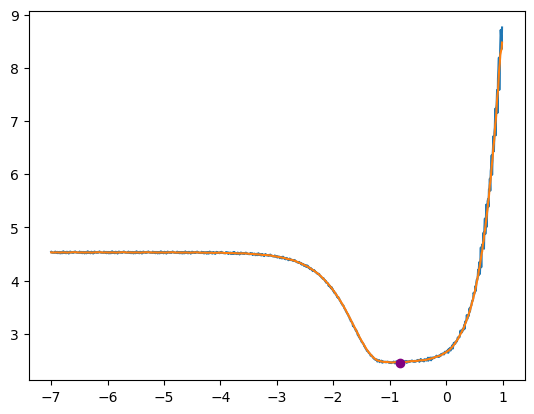

In [8]:
from training import train
from nn import Model
import matplotlib.pyplot as plt
from find_lr import find_lr
import numpy as np

torch.manual_seed(0)  # For reproducibility

model = Model(vocab)

optimal_lr, min_loss, lres, losses, smoothed_losses = find_lr(model, Loader(trn), lambda lr: torch.optim.AdamW(model.parameters(), lr=lr), return_info=True)

print(f"{min_loss=:.5f}")
print(f"{optimal_lr=:.5f}")

lr = optimal_lr

plt.plot(lres, losses)
plt.plot(lres, smoothed_losses, c="tab:orange")

# Plot the point where the loss is minimal
plt.scatter(np.log10(optimal_lr), min_loss, c="purple", zorder=2);

Initial model has loss 4.554506301879883


100%|██████████| 54/54 [00:00<00:00, 174.10it/s]


Epoch 0: training: 2.4669556617736816 validation: 2.5057549476623535


100%|██████████| 54/54 [00:00<00:00, 181.90it/s]


Epoch 1: training: 2.4644272327423096 validation: 2.5106253623962402


100%|██████████| 54/54 [00:00<00:00, 175.89it/s]


Epoch 2: training: 2.457030773162842 validation: 2.5061471462249756


100%|██████████| 54/54 [00:00<00:00, 180.03it/s]


Epoch 00004: reducing learning rate of group 0 to 7.7475e-02.
Epoch 3: training: 2.455885171890259 validation: 2.512030601501465


100%|██████████| 54/54 [00:00<00:00, 185.47it/s]


Epoch 4: training: 2.456085205078125 validation: 2.5107994079589844


100%|██████████| 54/54 [00:00<00:00, 184.96it/s]


Epoch 5: training: 2.4563632011413574 validation: 2.5043084621429443


100%|██████████| 54/54 [00:00<00:00, 185.07it/s]


Epoch 00007: reducing learning rate of group 0 to 3.8737e-02.
Epoch 6: training: 2.4594452381134033 validation: 2.5054478645324707


100%|██████████| 54/54 [00:00<00:00, 120.26it/s]


Epoch 7: training: 2.449397563934326 validation: 2.5047760009765625


100%|██████████| 54/54 [00:00<00:00, 199.89it/s]


Epoch 8: training: 2.4583797454833984 validation: 2.508673667907715


100%|██████████| 54/54 [00:00<00:00, 194.80it/s]


Epoch 00010: reducing learning rate of group 0 to 1.9369e-02.
Epoch 9: training: 2.4507386684417725 validation: 2.509722948074341
Best achieved validation loss: 2.5043084621429443


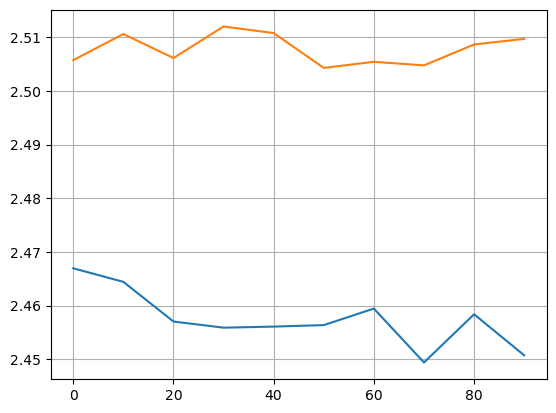

In [9]:
# Train the model
import os


torch.manual_seed(0)  # For reproducibility

model = Model(vocab)
model_name = "bigram"

if not os.path.exists(f"models/{model_name}.pt") or True:
    optim = torch.optim.AdamW(model.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=2, factor=0.5, threshold=0.05, verbose=True, min_lr=1e-5)

    loss_trn, loss_val = train(model, optim, Loader(trn), Loader(val), epochs=10, validate_freq=1, lr_scheduler=lr_scheduler, num_evaluations=10, device="cuda")

    epochs_ = torch.arange(len(loss_trn)) * 10
    plt.plot(epochs_, loss_trn, label="Training loss")
    plt.plot(epochs_, loss_val, label="Validation loss")
    plt.grid()
    plt.show()
else:
    model.load_state_dict(torch.load(f"models/{model_name}.pt"))
    model.eval()

    print("Loading model from file.")

    with torch.no_grad():
        print(f"Validation loss: {torch.tensor([model(batch, return_loss=True) for batch in Loader(val)]).mean().item()}")

# Now let's save it:
if not os.path.exists("models"):
    os.mkdir("models")

torch.save(model.state_dict(), f"models/{model_name}.pt")

In [105]:
model.eval()
print(model.generate("Hello", 1000))
model.train()

Hellofu ay IIn eald Clloimeabs bind mechithisur ig wen.
n;
Agheyougant
Nurninorak' ht ste ithunghe You l tou wim thethesan bur sth t r therean oile, ans f we in, w ave Nakn tathtll d amarid ld



Wail se wn vet I'eeck y y mofowevende do omef beld t toowan, s t bedeednere, f he Se hourom m m'schis bif ou meansol d ecaneld thithal felde bus theis, bllmis whey y maina-stharidill,
INIfrderteen.
TI pleces ot omy pppow--
S:
Weriesch STha; tr w on indyour al adyorlf s ge grein m t imave go od thang bef thar Whewele farel-pll ind,
I a
QUSellst ith, yotr anct I tount f BESBO:
PAD:
NIO:
LY: hend s ssertoord ce ING bes deme wnghine. IOFos:
nos thavencolwsen, cand t l



s hind b yser prow p,
ABOLLOLAnesharoupsesade ither thinchof ea camars oaken? r d Prefo h br teatoond te:
SCALAnts me a HESICarat t peamperIOFin win ashouithe t, K:
VENGRecon:
TOLLAD:
Yoor tesove h s lotend. m thust nangreavadvepsthaknthat

HAureean tod at: LOORY:
burey, yos
feesee wilanth he in we, moith makJonotoorpllyofalCis ma

Model(
  (embed): Embedding(65, 65)
)

In [7]:
from training import train
from nn import Transformer
import matplotlib.pyplot as plt
from find_lr import find_lr
import numpy as np

torch.manual_seed(0)  # For reproducibility

model = Transformer(vocab, block_size, embed_size=embed_size, num_heads=num_heads, num_blocks=num_blocks, dropout=dropout)

optimal_lr, min_loss, lres, losses, smoothed_losses = find_lr(model, Loader(trn), lambda lr: torch.optim.AdamW(model.parameters(), lr=lr), return_info=True, device=device)

print(f"{min_loss=:.5f}")
print(f"{optimal_lr=:.5f}")

lr = optimal_lr

plt.plot(lres, losses)
plt.plot(lres, smoothed_losses, c="tab:orange")

# Plot the point where the loss is minimal
plt.scatter(np.log10(optimal_lr), min_loss, c="purple", zorder=2);

KeyboardInterrupt: 

In [11]:
# Train the model
import os


torch.manual_seed(0)  # For reproducibility

model = Transformer(vocab, block_size, embed_size=embed_size, num_heads=num_heads, num_blocks=num_blocks, dropout=dropout)
model_name = "transformer"

# Print the model and total number of parameters
print(model)
print(f"Total number of parameters: {sum(p.numel() for p in model.parameters())}")

if not os.path.exists(f"models/{model_name}.pt") or True:
    optim = torch.optim.AdamW(model.parameters(), lr=3e-4)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, threshold=0.02, verbose=True, min_lr=1e-6)

    loss_trn, loss_val = train(model, optim, Loader(trn), Loader(val), epochs=100, validate_freq=1, lr_scheduler=lr_scheduler, num_evaluations=10, device=device)

    epochs_ = torch.arange(len(loss_trn)) * 10
    plt.plot(epochs_, loss_trn, label="Training loss")
    plt.plot(epochs_, loss_val, label="Validation loss")
    plt.grid()
    plt.show()
else:
    model.load_state_dict(torch.load(f"models/{model_name}.pt"))
    model.eval()

    print("Loading model from file.")

    with torch.no_grad():
        print(f"Validation loss: {torch.tensor([model(batch, return_loss=True) for batch in Loader(val)]).mean().item()}")

# Now let's save it:
if not os.path.exists("models"):
    os.mkdir("models")

torch.save(model.state_dict(), f"models/{model_name}.pt")

Transformer(
  (embed): Embedding(65, 384)
  (pos_embed): Embedding(256, 384)
  (blocks): Sequential(
    (0): Block(
      (heads): MultiHead(
        (heads): ModuleList(
          (0-5): 6 x Head(
            (keys): Linear(in_features=384, out_features=64, bias=False)
            (queries): Linear(in_features=384, out_features=64, bias=False)
            (values): Linear(in_features=384, out_features=64, bias=False)
            (dropout): Dropout(p=0.2, inplace=False)
          )
        )
        (dropout): Dropout(p=0.2, inplace=False)
      )
      (ff): FF(
        (ff): Sequential(
          (0): Linear(in_features=384, out_features=1536, bias=True)
          (1): ReLU()
          (2): Linear(in_features=1536, out_features=384, bias=True)
          (3): Dropout(p=0.2, inplace=False)
        )
      )
      (norm_pre_heads): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
      (norm_pre_ff): LayerNorm((384,), eps=1e-05, elementwise_affine=True)
    )
    (1): Block(
    

100%|██████████| 54/54 [00:34<00:00,  1.55it/s]


Epoch 0: training: 2.545942783355713 validation: 2.5884814262390137


 26%|██▌       | 14/54 [00:09<00:27,  1.44it/s]


KeyboardInterrupt: 

In [126]:
model.eval()
print(model.generate("ANDREW:", 1000))
model.train();

ANDREW:
Ay, lady and Saint Hath her hath do say breasts.

QUEEN MARGARET:
O, Marcius, Speak now, I pray King Edward,
Not Rivers, or and falseher from their should cryself,
That slain, which thy heart lords, they we are,
Doom'd you knowledge him and informent canscure,
Which she was in my head, he is Rome son,
And with Glouce thus never vengeance, go,
And, therefore I drop asparess not so false
Of the queen's Richard vow on that shall we heard
The sights of love of A west she return'd
Either of York strike prince by the fortune,
That your father draps traitor's newl-belly,
Let's this benefle's in our knighter'd wings,
And from 'general them wondering clock,
Play 
In find me have, those is't love us 'burbs;' therefore
The sweether in the while-king, when they thrown
My stummer's knife my son: prayers, I'll meet them boys,
But I'll not slow am hands: things you much
And makes not to a fail the bower and more.

PAULINA:
Why, sweet have so you other heart:
And, if I hadly truth, fair of dia

In [134]:
model.generate_continuous("the sacred flames will")

the sacred flames will he
grave e'er forth from his crustion!

FLORIZEL:
Nay, how now she insing that,
A debiest sendly-beat's blones, must new or teed.

ROMEO:
Be sight shall fight; but where it the bates took old?
We will the revolt! what not, thou mightle,
Graze I to know it you son and judgman
I am by thy meeding wills so desping:
My why cirs, followers, I not may your honour's,
Orld nothing poor Richard spirits; you must take yond
He warms, for what you way. You he's cousin,
Of that person thus oldied? where nows in hone?

spend! Seem on this house, you will no.

All:
Ay, my sene fathere.

LUCIO:
Yound he came; it is no lion, withart is mistrage,
Marry, With hit prison well; what look gleet's you king
Jove in o' Kish Rome! No, how now! you bower,
A man; but sointed in the shoulds of the eighted torth

Third Watchmandan: farest you must
To the goding: all him, famity, fair hears:
The fiery the will is suburr'd the lawful of chee!

EXETER:
I chall go, I'll can dear his day.

JULIET:

KeyboardInterrupt: 